DC Motor System
===============

Description of the problem
--------------------------

<img src="dc_motor_image.png" width="600" class="center"/>

The DC motor is a frequently used actuator that delivers immediate rotational
movement. By pairing it with components such as wheels, drums, or cables, it can
also generate linear motion. The input of the system is the voltage source ($V$) applied to
the motor's armature, while the output is the position of the shaft ($\theta$).
The rotor and shaft are assumed to be rigid. We further assume a viscous friction
model, that is, the friction torque is proportional to shaft angular velocity.

The differential equations, in state-space form, by choosing the motor position $x_1=\theta$,
motor speed $x_2 = \dot{\theta}$ and armature current $x_3=i$ as the state variables, are

\begin{align}
\dot{\boldsymbol{x}}(t) &= \begin{bmatrix} \dot{x}_1(t)\\ \dot{x}_2(t)\\ \dot{x}_3(t) \end{bmatrix} =
\begin{bmatrix} 0 & 1 & 0\\ 0 & -\dfrac{b}{J} & \dfrac{K}{J}\\ 0 & -\dfrac{K}{L} & -\dfrac{R}{L} \end{bmatrix}
\begin{bmatrix} x_1(t)\\ x_2(t)\\ x_3(t) \end{bmatrix} +
\begin{bmatrix} 0 \\ 0\\ \dfrac{1}{L} \end{bmatrix}V(t) =
A_c\boldsymbol{x}(t) + B_cu(t),\\
\boldsymbol{y}(t) &= \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}\begin{bmatrix} x_1(t)\\ x_2(t)\\ x_3(t) \end{bmatrix} =
C\boldsymbol{x}(t) + Du(t),\\
\end{align}
where
\begin{align}
A_c = \begin{bmatrix} 0 & 1 & 0\\ 0 & -\dfrac{b}{J} & \dfrac{K}{J}\\ 0 & -\dfrac{K}{L} & -\dfrac{R}{L} \end{bmatrix}, \quad
B_c = \begin{bmatrix} 0 \\ 0\\ \dfrac{1}{L} \end{bmatrix}, \quad
C = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}, \quad
D = \begin{bmatrix} 0 \\ 0 \end{bmatrix}.
\end{align}

To compare with the identified models, analytical discrete-time models are generated
by computing the state transition matrix (equivalent $A_k$) and the convolution integrals
(equivalent $B_k$ with a zero order hold assumption on the inputs). Because the system
matrices are time varying, matrix differential equations are given by
\begin{align}
\dot{\Phi}(t, t_k) = A(t)\Phi(t, t_k), \quad \dot{\Psi}(t, t_k) = A(t)\Psi(t, t_k) + I,
\end{align}
$\forall \ t \in [t_k, t_{k+1}]$, with initial conditions
\begin{align}
\Phi(t_k, t_k) = \begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix}, \quad
\Psi(t_k, t_k) = \begin{bmatrix} 0 & 0\\ 0 & 0 \end{bmatrix}
\end{align}
such that
\begin{align}
A_k = \Phi(t_{k+1}, t_k), \quad B_k = \Psi(t_{k+1}, t_k)B,
\end{align}
would represent the equivalent discrete-time varying system (true model).
For the current investigation, the time variation profiles for the resistance
and inductance are
\begin{align}
R(t) &= 4(1-\exp(-0.1t)),\\
L(t) &= 2.75e-6 + 1e-6sin(t).
\end{align}

The time interval of interest is 20 seconds, with the discretization sampling frequency set to be 10.

Given a time-history of $\boldsymbol{x}(t_k)$ and $u(t_k)$, the objective is to find a realization
$(\hat{A}_k, \hat{B}_k, \hat{C}_k, \hat{D}_k)$ of the discrete-time linear model.

Code
--------------------------

The code below shows how to use the python systemID package to find a linear representation
of the dynamics of the DC motor system.

First, import all necessary packages.

In [1]:
import systemID as sysID

import numpy as np
import scipy.linalg as LA
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams.update({"text.usetex": True, "font.family": "sans-serif", "font.serif": ["Computer Modern Roman"]})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

\
&nbsp;
\
&nbsp;
Define the parameters of the study. Data is collected at a frequency of 10Hz.

In [2]:
J = 3.2284e-6
b = 3.5077e-6
K = 0.0274
def R(t):
    return 2 * (1 + np.exp(-0.1 * t))
def L(t):
    return 2.75e-6 + 1e-6 * np.sin(t)

state_dimension = 3
input_dimension = 1
output_dimension = 1

frequency = 10
dt = 1/frequency

\
&nbsp;
\
&nbsp;
Create the continuous and then discrete-time system matrices.
Create the associated discrete linear model.

In [3]:
def Ac(t):
    return np.array([[0, 1, 0], [0, -b/J, K/J], [0, -K/L(t), -R(t)/L(t)]])

def dPhi(Phi, t):
    return np.matmul(Ac(t), Phi.reshape(state_dimension, state_dimension)).reshape(state_dimension ** 2)

def A(tk):
    A = odeint(dPhi, np.eye(state_dimension).reshape(state_dimension ** 2), np.array([tk, tk + dt]), rtol=1e-12, atol=1e-12)
    return A[-1, :].reshape(state_dimension, state_dimension)

def Bc(t):
    return np.array([[0], [0], [1/L(t)]])

def dPsi(Psi, t):
    return np.matmul(Ac(t), Psi.reshape(state_dimension, state_dimension)).reshape(state_dimension ** 2) + np.eye(state_dimension).reshape(state_dimension ** 2)

def B(tk):
    B = odeint(dPsi, np.zeros([state_dimension, state_dimension]).reshape(state_dimension ** 2), np.array([tk, tk + dt]), rtol=1e-12, atol=1e-12)
    return np.matmul(B[-1, :].reshape(state_dimension, state_dimension), Bc(tk))

def C(tk):
    return np.eye(state_dimension)

def D(tk):
    return np.zeros([output_dimension, input_dimension])

x0 = np.zeros(state_dimension)
true_system = sysID.discrete_linear_model(frequency, x0, A, B=B, C=C, D=D)

/usr/local/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


\
&nbsp;
\
&nbsp;
Generate an input signal for 5 seconds.

In [4]:
number_experiments = 20
total_time_training = 10
number_steps_training = int(total_time_training * frequency + 1)

forced_inputs_training = []
forced_outputs_training = []
for i in range(number_experiments):
    print(i)
    forced_input_training = sysID.discrete_signal(frequency=frequency, data=np.random.randn(number_steps_training))
    forced_output_training = sysID.propagate(forced_input_training, true_system)[0]
    forced_inputs_training.append(forced_input_training)
    forced_outputs_training.append(forced_output_training)

free_outputs_training = []
free_x0_training = 0.1 * np.abs(np.random.randn(state_dimension, number_experiments))
for i in range(number_experiments):
    print(i)
    model_free_response = sysID.discrete_linear_model(frequency, free_x0_training[:, i], A, B=B, C=C, D=D)
    free_output_training = sysID.propagate(sysID.discrete_signal(frequency=frequency, data=np.zeros([input_dimension, number_steps_training])), model_free_response)[0]
    free_outputs_training.append(free_output_training)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


\
&nbsp;
\
&nbsp;
Identification. The observer order is chosen to be 10. Parameters $p$ and $q$ for the
Hankel matrix are chosen to be $p=q=10$. The number of Markov parameters calculated is chosen
to be 50, enough to populate the Hankel matrix. Singular values are plotted to determine
the order of the system.

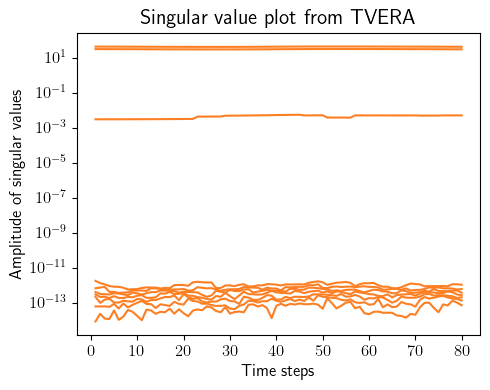

In [5]:
tvokid_ = sysID.tvokid(forced_inputs_training, forced_outputs_training, observer_order=10, number_of_parameters=50)

p = 10
q = p
tvera_ = sysID.tvera(tvokid_.hki, tvokid_.D, free_outputs_training, state_dimension, p, q, apply_transformation=True)

concatenated_singular_values = np.concatenate([arr[np.newaxis, 0:10] for arr in tvera_.Sigma[:-p]], axis=0).T

fig = plt.figure(num=1, figsize=[5, 4])

ax = fig.add_subplot(1, 1, 1)
for i in range(concatenated_singular_values.shape[0]):
    ax.semilogy(np.linspace(1, concatenated_singular_values.shape[1], concatenated_singular_values.shape[1]), concatenated_singular_values[i, :], color=(253/255, 127/255, 35/255))
plt.ylabel(r'Amplitude of singular values', fontsize=12)
plt.xlabel(r'Time steps', fontsize=12)
plt.title(r'Singular value plot from TVERA', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

x0_id = np.zeros(state_dimension)
identified_system = sysID.discrete_linear_model(frequency, x0_id, tvera_.A, B=tvera_.B, C=tvera_.C, D=tvera_.D)


\
&nbsp;
\
&nbsp;
Testing is accomplished using a sinusoidal signal for just under 10 seconds.

In [6]:
total_time_testing = 10 - (p+1) * dt
number_steps_testing = int(total_time_testing * frequency + 1)
tspan_testing = np.linspace(0, total_time_testing, number_steps_testing)

input_testing = sysID.discrete_signal(frequency=frequency, data=np.cos(5 * tspan_testing + np.pi/3))
output_testing_true = sysID.propagate(input_testing, true_system)[0]
output_testing_identified = sysID.propagate(input_testing, identified_system)[0]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


\
&nbsp;
\
&nbsp;
Plotting.

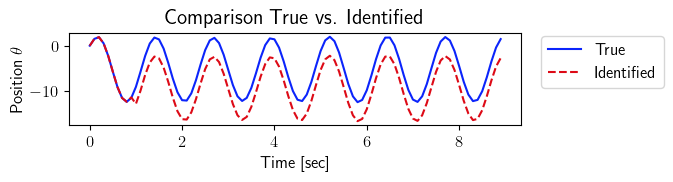

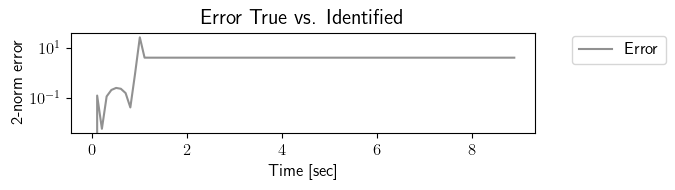

In [7]:
fig = plt.figure(num=2, figsize=[7, 3])

ax = fig.add_subplot(2, 1, 1)
ax.plot(tspan_testing, output_testing_true.data[0, :], color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing, output_testing_identified.data[0, :], '--', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.ylabel(r'Position $\theta$', fontsize=12)
plt.xlabel(r'Time [sec]', fontsize=12)
plt.title(r'Comparison True vs. Identified', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.05), ncol=1, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


fig = plt.figure(num=3, figsize=[7, 2])

ax = fig.add_subplot(1, 1, 1)
ax.semilogy(tspan_testing, LA.norm(output_testing_true.data - output_testing_identified.data, axis=0), color=(145/255, 145/255, 145/255), label=r'Error')
plt.ylabel(r'2-norm error', fontsize=12)
plt.xlabel(r'Time [sec]', fontsize=12)
plt.title(r'Error True vs. Identified', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.05), ncol=1, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


\
&nbsp;
\
&nbsp;
Eigenvalues of the true and raw identified models are compared. They don't match.

/usr/local/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


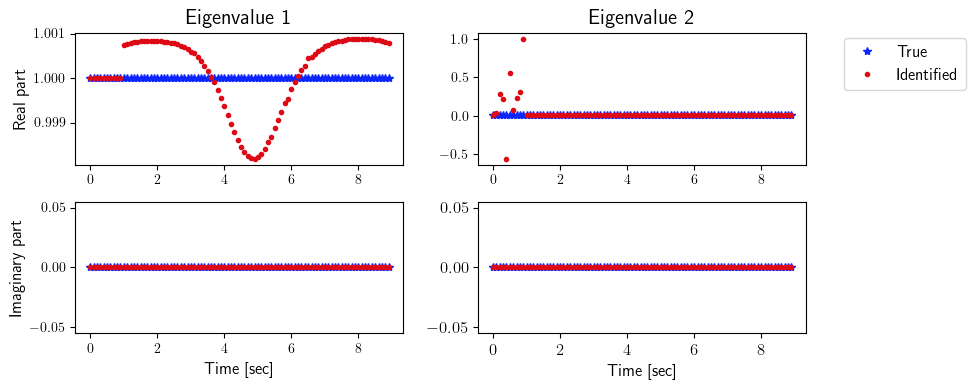

In [8]:
ev_true = np.zeros([2, state_dimension, number_steps_testing])
ev_identified = np.zeros([2, state_dimension, number_steps_testing])
for i in range(number_steps_testing):
    for j in range(state_dimension):
        ev_true[0, j, i] = np.real(LA.eig(true_system.A(i * dt))[0])[j]
        ev_true[1, j, i] = np.imag(LA.eig(true_system.A(i * dt))[0])[j]
        ev_identified[0, j, i] = np.real(LA.eig(identified_system.A(i * dt))[0])[j]
        ev_identified[1, j, i] = np.imag(LA.eig(identified_system.A(i * dt))[0])[j]

fig = plt.figure(num=4, figsize=[10, 4])

ax = fig.add_subplot(2, 2, 1)
ax.plot(tspan_testing, ev_true[0, 0, :], '*', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing, ev_identified[0, 0, :], '.', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.ylabel(r'Real part', fontsize=12)
plt.title(r'Eigenvalue 1', fontsize=15)

ax = fig.add_subplot(2, 2, 2)
ax.plot(tspan_testing, ev_true[0, 1, :], '*', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing, ev_identified[0, 1, :], '.', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.title(r'Eigenvalue 2', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1.02), ncol=1, fontsize=12)

ax = fig.add_subplot(2, 2, 3)
ax.plot(tspan_testing, ev_true[1, 0, :], '*', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing, ev_identified[1, 0, :], '.', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.ylabel(r'Imaginary part', fontsize=12)
plt.xlabel(r'Time [sec]', fontsize=12)

ax = fig.add_subplot(2, 2, 4)
ax.plot(tspan_testing, ev_true[1, 1, :], '*', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing, ev_identified[1, 1, :], '.', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.xlabel(r'Time [sec]', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

\
&nbsp;
\
&nbsp;
Eigenvalues of the true and corrected identified models are compared. They now match.



In [9]:
ev_true = np.zeros([2, state_dimension, number_steps_testing - p])
ev_identified = np.zeros([2, state_dimension, number_steps_testing - p])
for i in range(number_steps_testing - p):
    for j in range(state_dimension):
        O1_true = sysID.observability_matrix(true_system.A, true_system.C, p, tk=i * dt, dt=dt)
        O2_true = sysID.observability_matrix(true_system.A, true_system.C, p, tk=(i + 1) * dt, dt=dt)
        ev_true[0, j, i] = np.real(LA.eig(np.matmul(LA.pinv(O1_true), np.matmul(O2_true, true_system.A(i * dt))))[0])[j]
        ev_true[1, j, i] = np.imag(LA.eig(np.matmul(LA.pinv(O1_true), np.matmul(O2_true, true_system.A(i * dt))))[0])[j]

        O1_identified = sysID.observability_matrix(identified_system.A, identified_system.C, p, tk=i * dt, dt=dt)
        O2_identified = sysID.observability_matrix(identified_system.A, identified_system.C, p, tk=(i + 1) * dt, dt=dt)
        ev_identified[0, j, i] = np.real(LA.eig(np.matmul(LA.pinv(O1_identified), np.matmul(O2_identified, identified_system.A(i * dt))))[0])[j]
        ev_identified[1, j, i] = np.imag(LA.eig(np.matmul(LA.pinv(O1_identified), np.matmul(O2_identified, identified_system.A(i * dt))))[0])[j]

fig = plt.figure(num=4, figsize=[10, 4])

ax = fig.add_subplot(2, 2, 1)
ax.plot(tspan_testing[:-p], ev_true[0, 0, :], '*', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing[:-p], ev_identified[0, 0, :], '.', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.ylabel(r'Real part', fontsize=12)
plt.title(r'Eigenvalue 1', fontsize=15)

ax = fig.add_subplot(2, 2, 2)
ax.plot(tspan_testing[:-p], ev_true[0, 1, :], '*', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing[:-p], ev_identified[0, 1, :], '.', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.title(r'Eigenvalue 2', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1.02), ncol=1, fontsize=12)

ax = fig.add_subplot(2, 2, 3)
ax.plot(tspan_testing[:-p], ev_true[1, 0, :], '*', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing[:-p], ev_identified[1, 0, :], '.', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.ylabel(r'Imaginary part', fontsize=12)
plt.xlabel(r'Time [sec]', fontsize=12)

ax = fig.add_subplot(2, 2, 4)
ax.plot(tspan_testing[:-p], ev_true[1, 1, :], '*', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing[:-p], ev_identified[1, 1, :], '.', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.xlabel(r'Time [sec]', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)

KeyboardInterrupt

